# Naive Bayes Probabilistic ML - Titanic survival

Applying Naive Bayes to the [Kaggle Titanic dataset](https://www.kaggle.com/dimitreoliveira/naive-bayes-probabilistic-ml-titanic-survival), leveraging an existing [notebook](https://www.kaggle.com/dimitreoliveira/naive-bayes-probabilistic-ml-titanic-survival/notebook)

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score

%matplotlib inline
# Suppress warnings
warnings.filterwarnings("ignore")

In [2]:
def cross_validate(estimator, train, validation):
    X_train = train[0]
    Y_train = train[1]
    X_val = validation[0]
    Y_val = validation[1]
    train_predictions = classifier.predict(X_train)
    train_accuracy = accuracy_score(train_predictions, Y_train)
    train_recall = recall_score(train_predictions, Y_train)
    train_precision = precision_score(train_predictions, Y_train)

    val_predictions = classifier.predict(X_val)
    val_accuracy = accuracy_score(val_predictions, Y_val)
    val_recall = recall_score(val_predictions, Y_val)
    val_precision = precision_score(val_predictions, Y_val)

    print('Model metrics')
    print('Accuracy  Train: %.2f, Validation: %.2f' % (train_accuracy, val_accuracy))
    print('Recall    Train: %.2f, Validation: %.2f' % (train_recall, val_recall))
    print('Precision Train: %.2f, Validation: %.2f' % (train_precision, val_precision))

#### 1. Data loading and exploration

In [3]:
# Load the data
train_raw = pd.read_csv('data/titanic-kaggle/train.csv')
test_raw = pd.read_csv('data/titanic-kaggle/test.csv')
test_ids = test_raw['PassengerId'].values

# Join data to analyse and process the set as one.
train_raw['train'] = 1
test_raw['train'] = 0
data = train_raw.append(test_raw, sort=False)

In [4]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [6]:
data.shape

(1309, 13)

In [8]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,train
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,1309.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479,0.680672
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668,0.466394
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800,0.000000
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000,1.000000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200,1.000000


#### 2. Feature selection, data cleaning, feature engineering and data imputation

In [10]:
features = ['Age', 'Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp']
target = 'Survived'

data = data[features + [target] + ['train']]
# Categorical values need to be transformed into numeric.
data['Sex'] = data['Sex'].replace(["female", "male"], [0, 1])
data['Embarked'] = data['Embarked'].replace(['S', 'C', 'Q'], [1, 2, 3])
data['Age'] = pd.qcut(data['Age'], 10, labels=False)

In [11]:
data.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,train
0,2.0,1.0,7.2500,0,3,1,1,0.0,1
1,7.0,2.0,71.2833,0,1,0,1,1.0,1
2,4.0,1.0,7.9250,0,3,0,0,1.0,1
3,6.0,1.0,53.1000,0,1,0,1,1.0,1
4,6.0,1.0,8.0500,0,3,1,0,0.0,1


In [12]:
# Split data into train and test.
train = data.query('train == 1')
test = data.query('train == 0')

# Drop missing values from the train set.
train.dropna(axis=0, inplace=True)
labels = train[target].values

In [13]:
train.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,train
0,2.0,1.0,7.2500,0,3,1,1,0.0,1
1,7.0,2.0,71.2833,0,1,0,1,1.0,1
2,4.0,1.0,7.9250,0,3,0,0,1.0,1
3,6.0,1.0,53.1000,0,1,0,1,1.0,1
4,6.0,1.0,8.0500,0,3,1,0,0.0,1


#### Correlation Study
As we saw Naive Bayes models expect the features to be independent, so let's apply the Pearson correlation coefficient on them to give us a hint about how independent they are from the others.

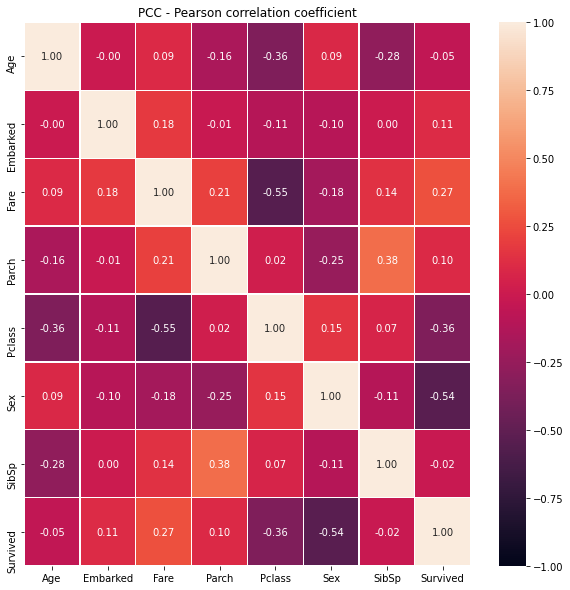

In [15]:
columns = train[features + [target]].columns.tolist()
nColumns = len(columns)
result = pd.DataFrame(np.zeros((nColumns, nColumns)), columns=columns)

# Apply Pearson correlation on each pair of features.
for col_a in range(nColumns):
    for col_b in range(nColumns):
        result.iloc[[col_a], [col_b]] = pearsonr(train.loc[:, columns[col_a]], train.loc[:,  columns[col_b]])[0]
        
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(result, yticklabels=columns, vmin=-1, vmax=1, annot=True, fmt='.2f', linewidths=.2)
ax.set_title('PCC - Pearson correlation coefficient')
plt.show()

About the correlation between the features, we can see that "Fare" and "Pclass" seem to be highly related, so i'll remove "Pclass". Also features like "Sex", "Pclass" and "Fare" should be good predictors.

##### Distribution Study
Also the model expect the features to come from a Gaussian (or normal) distribution, so let's check that as well.

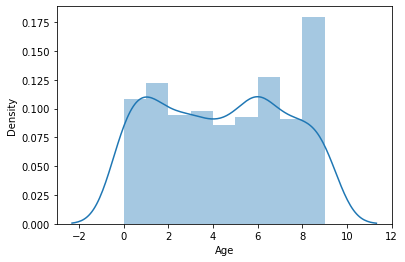

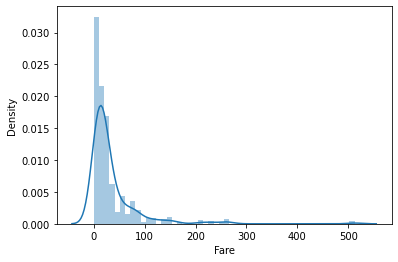

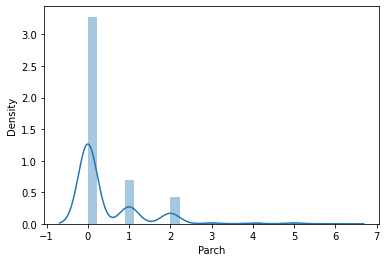

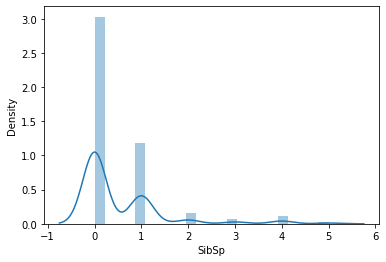

In [16]:
continuous_numeric_features = ['Age', 'Fare', 'Parch', 'SibSp']
for feature in continuous_numeric_features:
    sns.distplot(train[feature])
    plt.show()

Looking at our continuous numeric features we can see that "Fare", "Parch" and "SibSp", have a distribution close to normal, but with a left side skew, "Age" have a distribution a a bit different from the other but maybe it's close enough to Gaussian.

In [17]:
train.drop(['train', target, 'Pclass'], axis=1, inplace=True)
test.drop(['train', target, 'Pclass'], axis=1, inplace=True)

##### Split data in train and validation (80% ~ 20%)¶

In [18]:
X_train, X_val, Y_train, Y_val = train_test_split(train, labels, test_size=0.2, random_state=1)
X_train.head()

,Age,Embarked,Fare,Parch,Sex,SibSp
830,1.0,2.0,14.4542,0,0,1
566,1.0,1.0,7.8958,0,1,0
149,7.0,1.0,13.0000,0,1,0
106,2.0,1.0,7.6500,0,0,0
290,4.0,1.0,78.8500,0,0,0


##### Split train data into two parts

In [19]:
X_train1, X_train2, Y_train1, Y_train2 = train_test_split(X_train, Y_train, test_size=0.3, random_state=12)

#### 3. Refresher on Naive Bayes
This image may help to understand how a simple Bayesian model works.  
![](images/humidity-bayesian-network.png)

- Given that we have sun, rain and temperature events and we want to predict if will be humid or not, the probability of being humid will be calculated from the other given events ant theirs probabilities.
- In the boxes we have "sun" as a independent event, "rain" and "temp" as events that depends from "sun" and finally "humid" that depends from all the other.
- In the lower right text, we have the probability of "humid" being yes or no given that "sun" = yes (sun = 100%), so given that is sunny we have 46% probability of being humid and 54% probability of not being humid.


##### How Naive Bayes algorithm works?
- Convert the data set into a frequency table
- Create Likelihood table by finding the probabilities.
- Now, use Naive Bayesian equation to calculate the posterior probability for each class. The class with the highest posterior probability is the outcome of predic

In [21]:
classifier = GaussianNB()

In [22]:
# Fitting the data
classifier.fit(X_train2, Y_train2)

GaussianNB()

In [23]:
print('Metrics with only 30% of train data')
cross_validate(classifier, (X_train, Y_train), (X_val, Y_val))

Metrics with only 30% of train data
Model metrics
Accuracy  Train: 0.79, Validation: 0.76
Recall    Train: 0.75, Validation: 0.71
Precision Train: 0.71, Validation: 0.71


##### Update the model with the second part
Nice thing about this kind of model, you can update it by just fitting the model again with more data.

In [24]:
classifier.partial_fit(X_train1, Y_train1)

GaussianNB()

In [25]:
print('Metrics with the remaining 70% of train data')
cross_validate(classifier, (X_train, Y_train), (X_val, Y_val))

Metrics with the remaining 70% of train data
Model metrics
Accuracy  Train: 0.80, Validation: 0.76
Recall    Train: 0.78, Validation: 0.70
Precision Train: 0.69, Validation: 0.69


As you can see our results improved after we updated the model with the remaining data.
The sklearn model also give us some interesting options from the model API about the target class.

In [26]:
print('Probability of each class')
print('Survive = 0: %.2f' % classifier.class_prior_[0])
print('Survive = 1: %.2f' % classifier.class_prior_[1])

Probability of each class
Survive = 0: 0.60
Survive = 1: 0.40


In [28]:
print('Mean of each feature per class')
print('               Age         Embarked   Fare         Parch       Sex         SibSp')
print('Survive = 0: %s' % classifier.theta_[0])
print('Survive = 1: %s' % classifier.theta_[1])

Mean of each feature per class
               Age         Embarked   Fare         Parch       Sex         SibSp
Survive = 0: [ 4.5339233   1.23893805 22.97357316  0.37463127  0.86135693  0.5280236 ]
Survive = 1: [ 4.27391304  1.33478261 53.52155957  0.52608696  0.33043478  0.49130435]


In [29]:
print('Variance of each feature per class')
print('Survive = 0: %s' % classifier.sigma_[0])
print('Survive = 1: %s' % classifier.sigma_[1])

Variance of each feature per class
Survive = 0: [8.32554825e+00 2.88044224e-01 8.60096730e+02 8.36055467e-01
 1.19424042e-01 1.11647419e+00]
Survive = 1: [8.45106148e+00 2.74880003e-01 5.28959488e+03 6.75409304e-01
 2.21250514e-01 4.41231610e-01]


In [30]:
# Unfortunately sklearn naive Bayes algorithm currently do not make inference with missing data (but should do), so we need to input missing data.
test.fillna(test.mean(), inplace=True)
test_predictions = classifier.predict(test)
submission = pd.DataFrame({'PassengerId': test_ids})
submission['Survived'] = test_predictions.astype('int')
submission.to_csv('submission.csv', index=False)
submission.head(10)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


What are the Pros and Cons of Naive Bayes?
Pros:
- Humans are not good with reasoning in systems with limited or conflicting information. It would be handy if we have something to manage all this limited/conflicting information.
- It is easy and fast to predict class of test data set. It also perform well in multi class prediction
- When assumption of independence holds, a Naive Bayes classifier performs better compare to other models like logistic regression and you need less training data.
- It perform well in case of categorical input variables compared to numerical variable(s). For numerical variable, normal distribution is assumed (bell curve, which is a strong assumption).


Cons:
- Probably the most notable weakness of BNs is the designing methodology.There is no standard way of building BNs.
- If categorical variable has a category (in test data set), which was not observed in training data set, then model will assign a 0 (zero) probability and will be unable to make a prediction. This is often known as “Zero Frequency”. To solve this, we can use the smoothing technique. One of the simplest smoothing techniques is called Laplace estimation.
- On the other side naive Bayes is also known as a bad estimator, so the probability outputs from predict_proba are not to be taken too seriously.
- Another limitation of Naive Bayes is the assumption of independent predictors. In real life, it is almost impossible that we get a set of predictors which are completely independent.